In [3]:
import json
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
from umap import UMAP
import os
import torch
import re
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
# check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"目前使用的設備是: {device}")

目前使用的設備是: cuda


In [5]:
#######################
# 用來把留言中的url清除
#######################

def clean_text(text):
    # 1. 移除網址 (http, https, ftp, www)
    text = re.sub(r'http\S+|www\.\S+', '', text)
    # 2. 移除一些社群常見的雜訊 (可選)
    # 例如：移除重複的換行或多餘空格
    text = text.replace('\n', ' ').strip()
    return text

In [26]:
##############
# Read data
##############

input_file_name = "ig_comments.json"

with open(input_file_name, "r", encoding="utf-8") as f:
    comments_dict = json.load(f)
print(f"成功從{input_file_name}讀取檔案至comments_dict\n")

# 將全部留言存到all_comments
all_comments = []
for artist in comments_dict:
    all_comments += comments_dict[artist]
    
#把留言中的url刪掉
all_comments_cleaned = [clean_text(str(c)) for c in all_comments if len(clean_text(str(c))) > 2]
print("成功將所有留言存入all_comments_cleaned，並去除留言內的url\n")


成功從ig_comments.json讀取檔案至comments_dict

成功將所有留言存入all_comments_cleaned，並去除留言內的url



In [21]:
############
# Settings
############

# 1. 向量化模型 (使用多語言支援)
embedding_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

# 2. 降維模型 (UMAP): 影響分群的精細度
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

# 3. 聚類模型 (HDBSCAN): 自動偵測分群
# min_cluster_size: 一個主題最少要有幾則留言 (可根據資料量調整)
hdbscan_model = HDBSCAN(min_cluster_size=40, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

# 4. 關鍵字提取 (Vectorizer): 排除停用詞
vectorizer_model = CountVectorizer(stop_words=["的", "了", "在", "是", "我", "https", "com"])

print("設定元件完畢")

設定元件完畢


In [22]:
#############
# Training
#############
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    verbose=True
)

topics, probs = topic_model.fit_transform(all_comments_cleaned)

2025-12-23 11:56:10,694 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 146/146 [00:02<00:00, 72.42it/s]
2025-12-23 11:56:12,746 - BERTopic - Embedding - Completed ✓
2025-12-23 11:56:12,755 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-23 11:56:19,989 - BERTopic - Dimensionality - Completed ✓
2025-12-23 11:56:19,989 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-23 11:56:20,185 - BERTopic - Cluster - Completed ✓
2025-12-23 11:56:20,185 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-23 11:56:20,225 - BERTopic - Representation - Completed ✓


In [23]:
#########################################################################
# 如果Topic=-1的文本太多了，執行以下程式，把一些outliers分到最靠近的群體裏面
#########################################################################

# 將離群值分配給最相似的主題
new_topics = topic_model.reduce_outliers(all_comments_cleaned, topics)

# 更新模型中的主題標籤
topic_model.update_topics(all_comments_cleaned, topics=new_topics)

100%|██████████| 2/2 [00:00<00:00, 110.88it/s]
2025-12-23 11:56:20,357 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [24]:
###################
# 結果（文字）　
###################

# 取得主題清單 (-1 代表雜訊/不屬於任何主題)
topic_info = topic_model.get_topic_info()
print(topic_info.head(10))

# 儲存結果
topic_info.to_csv("hdbscan_topics.csv", index=False, encoding="utf-8-sig")


   Topic  Count                                  Name  \
0     -1   1072               -1_66小吃店_toro_在哪裡_chill   
1      0    467                     0_我們都在_達哥加油_達哥_加油   
2      1    267                         1_好帥_好聽_哈哈_期待   
3      2    245            2_加油加油_高雄_就正常的啊_xian_a1021   
4      3    244  3_gagahsu1024_spencer_bj4_minmin3397   
5      4    193                      4_置板凳_陳零九_九哥_打勾勾   
6      5    186                    5_達達加油_坤達加油_修楷杰_水哥   
7      6    206               6_歡迎回來_back_回來了_welcome   
8      7    147                     7_09加油_09_零九加油_零九   
9      8    139               8_等你回來_我們等你回來_等你回歸_好好處理   

                                      Representation  \
0  [66小吃店, toro, 在哪裡, chill, 我哭了, 對你很失望, 我只是來置板凳,...   
1  [我們都在, 達哥加油, 達哥, 加油, 我們一直都在, 沒事, 支持你, 永遠支持你, 好...   
2       [好帥, 好聽, 哈哈, 期待, 好棒, 好好聽, 好帅, 歐買尬, 超讚, 達哥好帥]   
3  [加油加油, 高雄, 就正常的啊, xian_a1021, 好好吃飯, 大牙加油, 好吃, ...   
4  [gagahsu1024, spencer, bj4, minmin3397, ____ld...   
5  [置板凳, 陳零九, 九哥, 打勾勾, your, 小馬, 哈哈哈

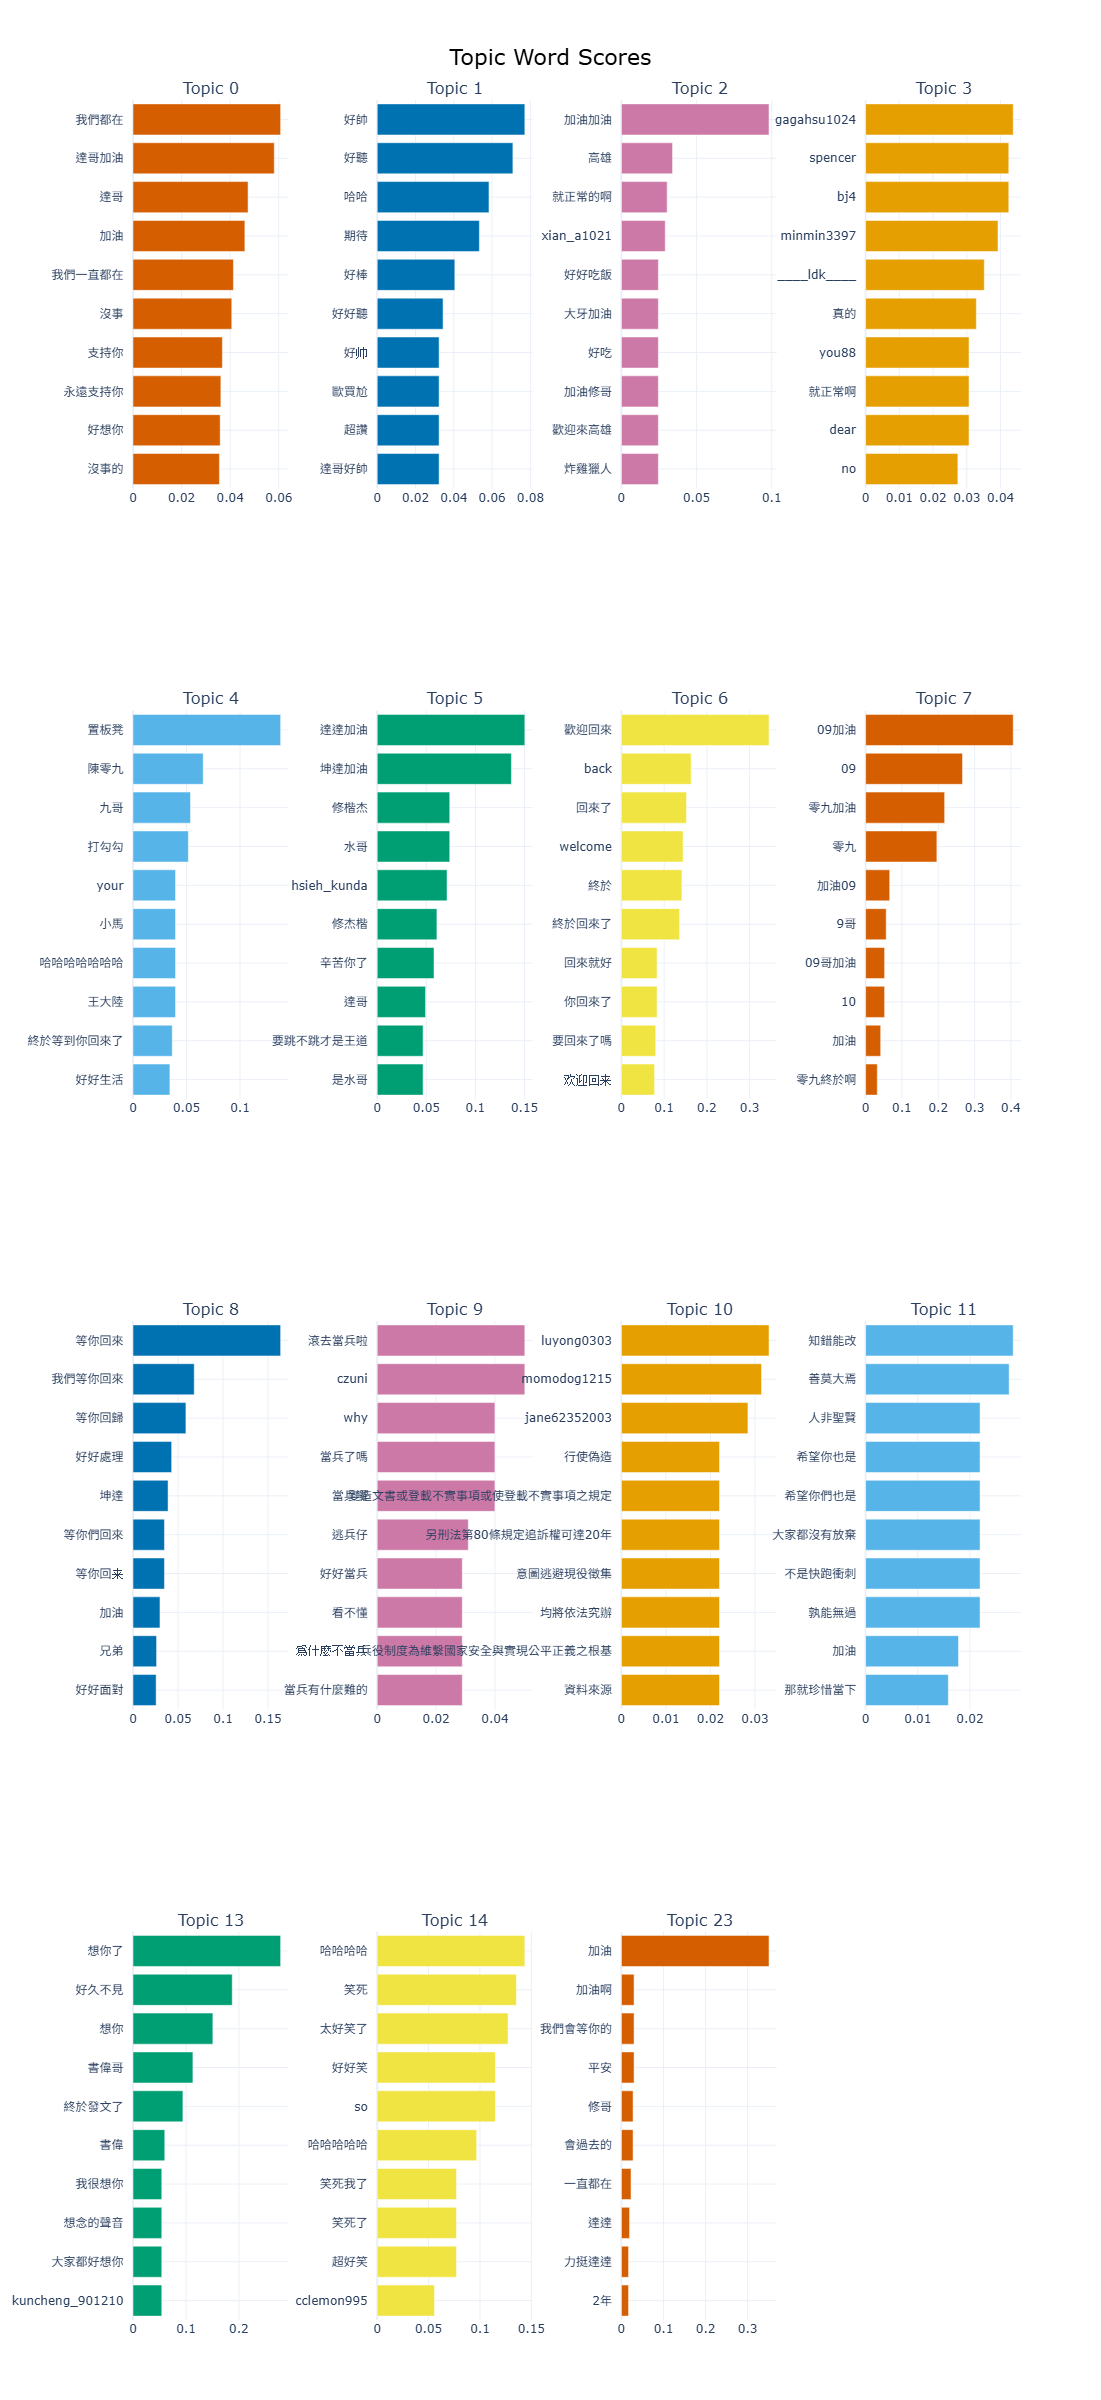

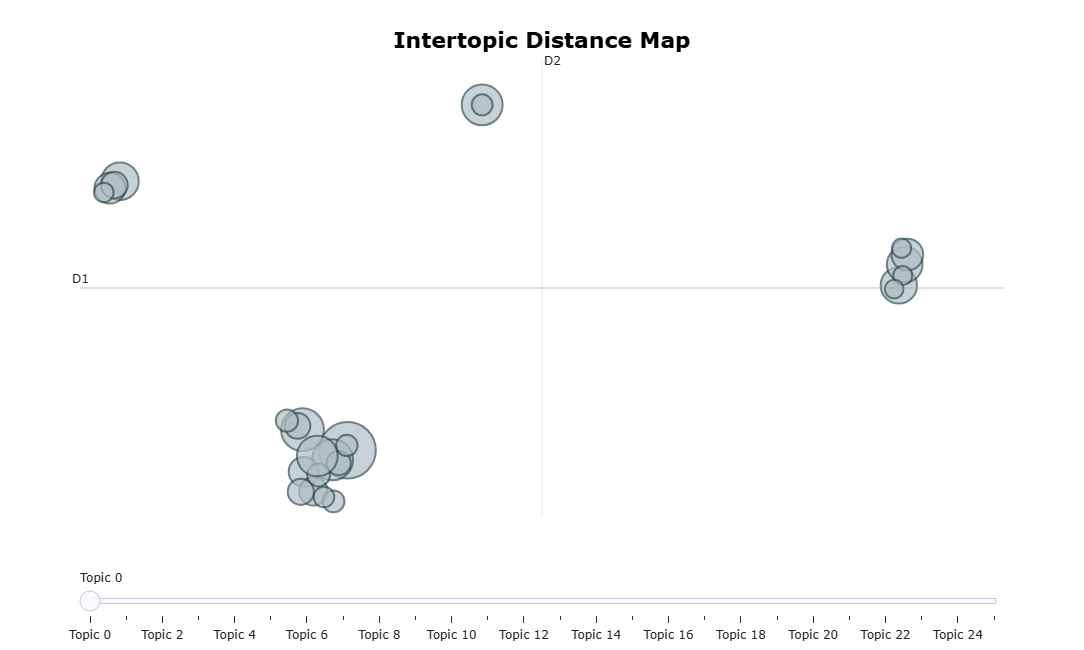

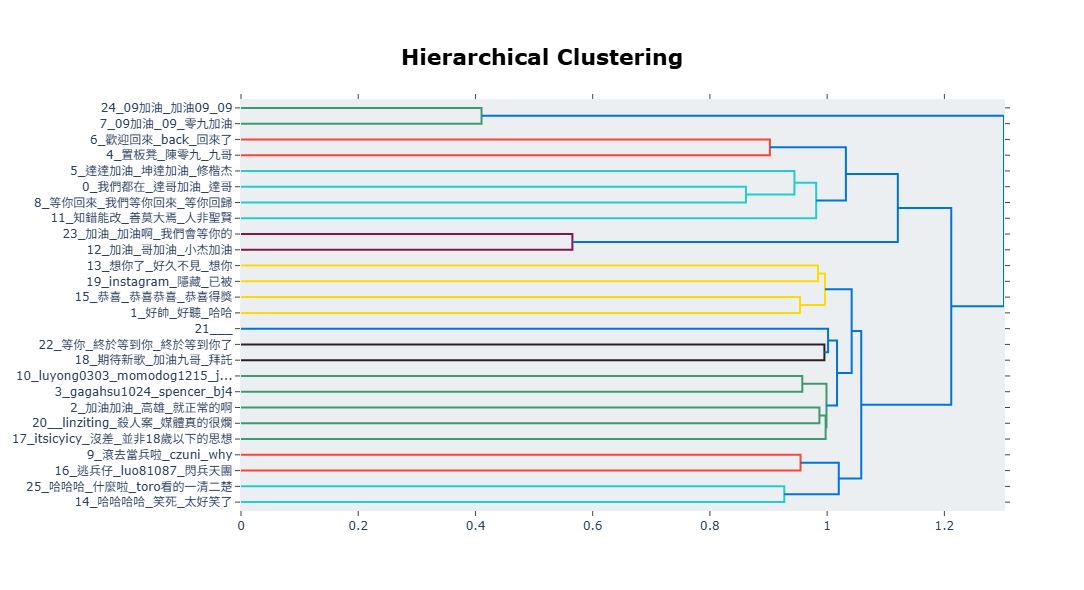

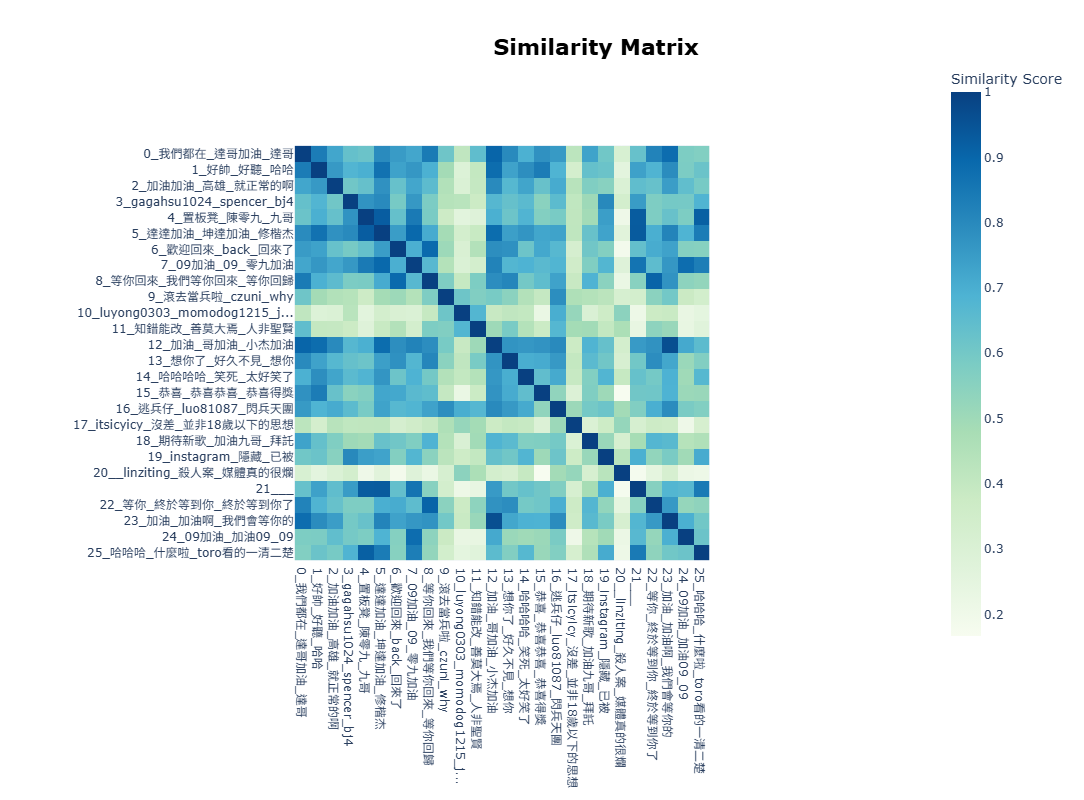

In [25]:
###############
# 圖形化顯示
###############

# top_n_topics: 顯示前幾個主題
# n_words: 每個主題顯示幾個關鍵字
fig1 = topic_model.visualize_barchart(top_n_topics=15, n_words=10, height=600)
fig1.show()

# 儲存為 HTML 檔（可以用瀏覽器開啟，保留互動功能）
fig1.write_html("topic_barchart.html")

# intertopic distance map
fig2 = topic_model.visualize_topics()
fig2.show()
fig2.write_html("topic_distance_map.html")

# Hierarchy
fig3 = topic_model.visualize_hierarchy()
fig3.show()
fig3.write_html("topic_hierarchy.html")

# Heat Map
fig4 = topic_model.visualize_heatmap()
fig4.show()
fig4.write_html("topic_heatmap.html")